In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import dask.dataframe as dd
from dask.distributed import Client
import xarray as xr

In [ ]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
def open_files(variable,lat_start,lat_end,lon_start,lon_end):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"
            ] #"202203-202203","202204-202204": removed as not in radar domain; barra goes back to 2007 (radar till 08-2011)
    fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable+"/"
    data = []
    for months in list:
        # to get specific hour, edit: u.ua850.isel(time=(barra2_202201.time.dt.hour == hour)
        var = xr.open_dataset(fp+variable+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+months+".nc", engine="h5netcdf",chunks="auto")#{'time':-1})
        mean = var[variable].sel(lat=slice(lat_start,lat_end),lon=slice(lon_start,lon_end))
        var_mean = mean.mean(dim=["lat","lon"])    
        data.append(var_mean)
    return data

In [5]:
%%time
# wind_mean_u = open_files("ua850",-20.768799,-18.0708,145.12054,147.9812) #townsville
# wind_mean_v = open_files("va850",-20.768799,-18.0708,145.12054,147.9812) #townsville
# wind_mean_u = open_files("ua850",-18.165955,-15.468018,144.27374,147.09222) #cairns
# wind_mean_v = open_files("va850",-18.165955,-15.468018,144.27374,147.09222) #cairns
# wind_mean_u = open_files("ua850",-17.636353,-14.938416,148.55927,151.36993) #willis island
# wind_mean_v = open_files("va850",-17.636353,-14.938416,148.55927,151.36993) #willis island

In [6]:
%%time
concat_u_towns = xr.concat(wind_mean_u_towns,"time")
concat_v_towns = xr.concat(wind_mean_v_towns,"time")
concat_u_cairns = xr.concat(wind_mean_u_cairns,"time")
concat_v_cairns = xr.concat(wind_mean_v_cairns,"time")

In [ ]:
%%time
uu_towns = (concat_u_towns * units("m/s")).compute()
vv_towns = (concat_v_towns * units("m/s")).compute()
uu_cairns = (concat_u_cairns * units("m/s")).compute()
vv_cairns = (concat_v_cairns * units("m/s")).compute()

In [7]:
wind_dir = metpy.calc.wind_direction(uu, vv, convention='from')
wind_speed = metpy.calc.wind_speed(uu, vv)

In [8]:
direction = wind_dir.values
speed = wind_speed.values

In [9]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
            "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
            "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
           ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="netcdf4")

In [10]:
# open radar ds
# ds_radar_T = open_radar_ds("73")
ds_radar_C = open_radar_ds("19")
#ds_radar_W = open_radar_ds("41")

In [11]:
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)

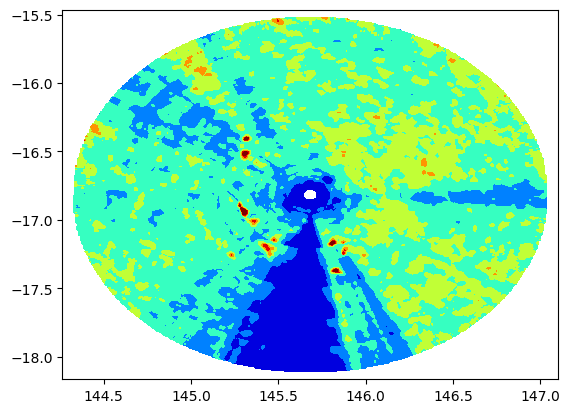

In [36]:
# calculate mean precip over x,y
radar_mean = ds_radar_C.rainrate.mean(dim="time")
# create masked data by threshold set at 1.5mm/h
masked_ds = xr.where((radar_mean < 1.5), np.nan, radar_mean)
 ########
# calc winds
winds = wind_dir[(wind_dir>180*units("degree"))&(wind_dir<360*units("degree"))]
    # select wind time values
wind_times = winds.time.values
wind_times.sort() 

    # select radar data times which closest equal to easterly times
mean_rr = ds_radar_C.rainrate.sel(time=wind_times,method="nearest").mean(dim=["time"]) 

    # mask data
masked_data = xr.where(masked_ds==np.nan, np.nan,mean_rr)
plt.contourf(ds_radar_C.longitude.isel(time=0),ds_radar_C.latitude.isel(time=0),masked_data,levels=10,vmin=0,vmax=6,cmap="jet",alpha=1)
